## Красота вычислительной геометрии или что можно сделать алгоритмом построения выпуклой оболочки

<b>Определение 1.</b> Выпуклая оболочка $CH$ множества точек $P$ — минимальное по включению выпуклое множество, содержащее $P$.

Выпуклая оболочка множества точек — выпуклый многогранник.

Данная лекция-семинар о том, как, имея функцию, вычисляющую выпуклую оболочку, построить пересечение полуплоскостей и триангуляцию Делоне.

### Выпуклая оболочка на плоскости

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


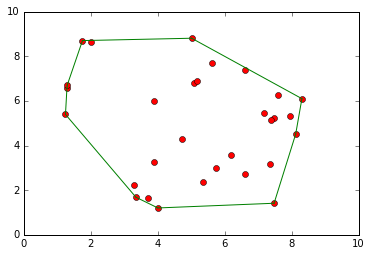

In [16]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

from pyhull.convex_hull import ConvexHull

X, Y = np.random.uniform(1, 9, size=(2, 30))
ch = ConvexHull(np.transpose([X, Y]))

plt.plot(X, Y, "ro")
for v in ch.vertices:
    plt.plot(X[v], Y[v], "g")
    
plt.axis([0, 10, 0, 10])
plt.show()

### Оболочка в 3D

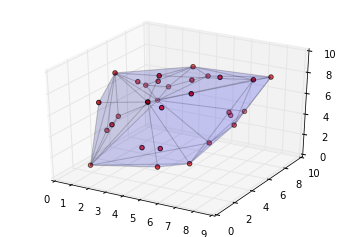

In [17]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from pyhull.convex_hull import ConvexHull

X, Y, Z = np.random.uniform(1, 9, size=(3, 30))
ch = ConvexHull(np.transpose([X, Y, Z]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, c='r')
ax.plot_trisurf(X, Y, Z, alpha=0.1, triangles=ch.vertices)
    
plt.show()

### Пересечение полуплоскостей

Рассмотрим множество полуплоскостей, заданных нормалью $n$ и точкой $p$ на прямой, ограничивающей соответствующую полуплоскость (напомню неравенство для $i$-й полуплоскости: $n_i \cdot (p - p_i) \le 0$). Потребуем, чтобы все нормали были ориентированы вертикально, то есть, чтобы $n_y \gt 0$. Точка $(x,y)$ пересечения прямых, ограничивающих полуплоскости, является решением системы уравнений:

$$
\left\{
    \begin{array}{ll}
        n_{1x} x + n_{1y} y = n_1 \cdot p_1\\
        n_{2x} x + n_{2y} y = n_2 \cdot p_2
    \end{array}
\right.
$$

$$
x = \frac{
    \begin{vmatrix}
    n_1 \cdot p_1 && n_{1y} \\
    n_2 \cdot p_2 && n_{2y}
    \end{vmatrix}}{
    \begin{vmatrix}
    n_{1x} && n_{1y} \\
    n_{2x} && n_{2y} 
    \end{vmatrix}}\space\space\space
y = \frac{
    \begin{vmatrix}
    n_{1y} && n_1 \cdot p_1 \\
    n_{2y} && n_2 \cdot p_2
    \end{vmatrix}}{
    \begin{vmatrix}
    n_{1x} && n_{1y} \\
    n_{2x} && n_{2y} 
    \end{vmatrix}}
$$

Заметим, что если нормали $n_1, n_3$ и $n_2$ упорядочены по повороту и точка пересечения прямых $l_1$ и $l_2$ лежит в полуплоскости $h_3$, то эту полуплоскость можно выкинуть из рассмотрения: вклад в пересечение полуплоскостей она не даёт. ![Пересекающиеся полуплоскости](images/intersecting_segments.svg) Это условие выражается формулой $n_{3x} x + n_{3y} y - n_3 \cdot p_3 \lt 0$. Упорядоченность по повороту даёт знак определителя

$$
\begin{vmatrix}
    n_{1x} && n_{1y} \\
    n_{2x} && n_{2y} 
\end{vmatrix} \lt 0
$$

Домножим на него, получим

$$
n_{3x} \begin{vmatrix} n_1 \cdot p_1 && n_{1y} \\ n_2 \cdot p_2 && n_{2y} \end{vmatrix} + 
n_{3y} \begin{vmatrix} n_{1y} && n_1 \cdot p_1 \\ n_{2y} && n_2 \cdot p_2 \end{vmatrix} -
n_3 \cdot p_3 \begin{vmatrix} n_{1x} && n_{1y} \\ n_{2x} && n_{2y} \end{vmatrix} \gt 0
$$

Что эквивалентно

$$
\begin{vmatrix}
    n_{1x} && n_1 \cdot p_1 && n_{1y} \\
    n_{2x} && n_2 \cdot p_2 && n_{2y} \\
    n_{3x} && n_3 \cdot p_3 && n_{3y}
\end{vmatrix} \gt 0
$$

Что эквивалентно проверке поворота в двойственном пространстве точек с _однородными координатами_ $(n_{ix}, n_i \cdot p_i, n_{iy})$ или, после деления на $n_{iy}$:

$$
\left(\frac{n_{ix}}{n_{iy}}, \frac{n_i \cdot p_i}{n_{iy}}, 1\right)
$$

Отметим, что точкам, упорядоченным по координате $x$ соответствуют полуплоскости, упорядоченные по повороту нормалей.

Таким образом, _верхняя оболочка_ множества точек в двойственном пространстве даст последовательность полуплоскостей, составляющих границу пересечения.

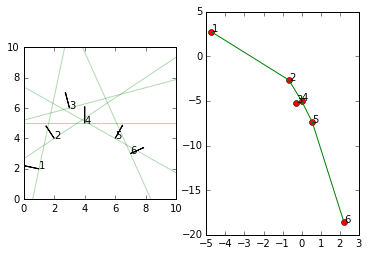

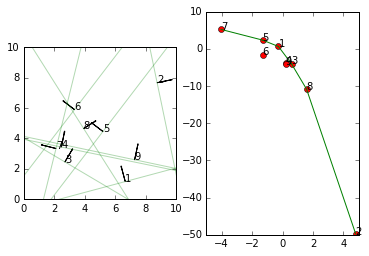

In [18]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from pyhull.convex_hull import ConvexHull
from math import sqrt


def process_data(Nx, r):
    Ny = np.ones(len(Nx)) - Nx**2
    X, Y = r[:, 0], r[:, 1]

    Xd, Yd = Nx / Ny, -(Nx * X + Ny * Y) / Ny

    ch = ConvexHull(np.transpose([Xd, Yd]))

    ax = plt.subplot(1, 2, 1, aspect="equal")

    for i, (x, y, nx, ny) in enumerate(zip(X, Y, Nx, Ny), 1):
        ax.arrow(x, y, nx, ny, head_width=0.05, head_length=0.1, fc="k", ec="k")
        ax.plot([x + ny * 100, x - ny * 100], 
                [y - nx * 100, y + nx * 100], "g", alpha=0.3)
        ax.text(x, y, i)

    ax.axis([0, 10, 0, 10])

    ax = plt.subplot(1, 2, 2)

    ax.plot(Xd, Yd, "ro")
    for i, (x, y) in enumerate(zip(Xd, Yd), 1):
        ax.text(x, y, i)

    for v in ch.vertices:
        if Xd[v[0]] > Xd[v[1]]:
            ax.plot(Xd[v], Yd[v], "g")

    plt.show()
    
process_data(np.array([-0.9, -0.5, -0.25, 0, 0.45, 0.8]), 
             np.array([[1, 2], [2, 4], [3, 6], [4, 5], [6, 4], [7, 3]]))

npoints = 9
np.random.seed(42)
process_data(np.random.uniform(-1, 1, size=npoints),
             np.random.uniform(1, 9, size=(npoints, 2)))


### Триангуляция Делоне на плоскости

Рассмотрим _триангуляцию_ $T$ множества точек $P$. $T$ называется _триангуляцией Делоне_, если внутренность проведённого около любого треугольника $t \in T$ круга $c$ не содержит точек из $P$. Сопоставим каждой точке $p \in P$ точку $p' = (p_x, p_y, p^2)$ (спроецируем точки на параболоид). Из уравнения полупространства $n \cdot (p - p_0) \le 0$ и параболоида $z=x^2+y^2$ следует, что множество точек пересечения параболоида полупространством будет удовлетворять уравнению $ax+by+c(x^2+y^2)+d \le 0$, что является уравнением круга $(p - p_0)^2 \le r^2$ в случае, если нормаль к плоскости $n=(a, b, c)$ будет направлена вверх ($c \gt 0$).

Чему будет эквивалентна триангуляция Делоне?

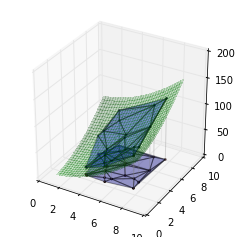

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d', aspect="equal")
X = np.arange(1, 9, 0.25)
Y = np.arange(1, 9, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2, color="g",
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 200)
ax.axis([0, 10, 0, 10])

r = np.random.uniform(2, 8, size=(20, 2))
X, Y = r[:, 0], r[:, 1]
Z = X ** 2 + Y ** 2
ax.scatter(X, Y, np.zeros(len(r)), c="r", s=3)
ax.scatter(X, Y, Z, c="b", s=3)

ch = ConvexHull(np.transpose([X, Y, Z]))
triangles = [[a, b, c] for a, b, c in ch.vertices if (X[a] - X[c]) * (Y[b] - Y[c]) > (X[b] - X[c]) * (Y[a] - Y[c])]
ax.plot_trisurf(X, Y, Z, alpha=0.4, triangles=triangles, color="b")
ax.plot_trisurf(X, Y, np.zeros(len(r)), alpha=0.4, triangles=triangles, color="b")

for x, y in r:
    ax.plot([x, x], [y, y], "gray", alpha=0.3, zs=[0, x**2 + y**2])

plt.show()

### Триангуляция Делоне в 3D

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from pyhull.convex_hull import ConvexHull

np.random.seed(321)
X, Y, Z = np.random.uniform(1, 9, size=(3, 7))
ch = ConvexHull(np.transpose([X, Y, Z, X**2 + Y**2 + Z**2]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect="equal")

ax.scatter(X, Y, Z, c="b", s=3)

for v in ch.vertices:
    t = v + [v[0]]
    ax.plot(X[t], Y[t], "g", zs=Z[t])

ax.axis([0, 10, 0, 10])
ax.set_zlim(0, 10)

plt.show()

### Триангуляция Делоне на сфере

Аналогично введём триангуляцию Делоне на сфере. Рассмотрим множество точек $P$ на сфере $S$. Скажем, что _триангуляция_ множества точек $P$ является _триангуляцией Делоне_, если внутренность описанного около каждого треугольника $t$ _круга_ $c$ не содержит точек из $P$. Существование триангуляции Делоне следует из того, что окружность — это пересечение плоскости, а круг — это пересечение полупространства со сферой $S$.

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from pyhull.convex_hull import ConvexHull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect="equal")

a, b, c, d = 0.5, 0.5, 0.5, 5
x, y = np.transpose([[-10, -10], [-10, 10], [10, 10], [10, -10]])
z = (d - a * x - b * y) / c
ax.plot_trisurf(x, y, z, triangles=[[0, 1, 2], [0, 2, 3]], color='r', alpha=0.5, linewidth=0)

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, alpha=0.2, rstride=4, cstride=4, color='b', linewidth=0.5)

ax.axis([-11, 11, -11, 11])
ax.set_zlim(-11, 11)

plt.show()

Поэтому условие "точка не лежит внутри круга $c$" переформулируется как "точка не лежит в полупространстве, пересекающем сферу $S$". Чем является триангуляция Делоне в этом случае?

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from pyhull.convex_hull import ConvexHull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect="equal")

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, alpha=0.2, rstride=4, cstride=4, color='b', linewidth=0)

u, t = np.random.uniform(-1, 1, 120), np.random.uniform(0, 2*pi, 120)
ones = np.ones(len(u))
X = 10 * np.sqrt(ones - u ** 2) * np.cos(t)
Y = 10 * np.sqrt(ones - u ** 2) * np.sin(t)
Z = 10 * u

ax.scatter(X, Y, Z, c="b", s=3)

ch = ConvexHull(np.transpose([X, Y, Z]))
ax.plot_trisurf(X, Y, Z, alpha=0.9, triangles=ch.vertices)

ax.axis([-11, 11, -11, 11])
ax.set_zlim(-11, 11)

plt.show()